## Transfer Learning with TensorFlow, scaling up (🍔👀Food Vision mini)

We've seen the power of transfer learning feature extraction and fine_tuning, now it's time to scale up to all of the classes in food101 (101 totl classes of food).

Our goual is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Original Food101 paper [here](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf).

Our baseline to beat is 50.76% accuracy across 101 classes

In [1]:
# Check connection
!nvidia-smi

Sat Sep 24 22:28:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

Download the helper functions

In [2]:
!wget https://raw.githubusercontent.com/JonasHagstrom79/Tensorflow/main/helper.py

--2022-09-24 22:28:58--  https://raw.githubusercontent.com/JonasHagstrom79/Tensorflow/main/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10235 (10.0K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  10.00K  --.-KB/s    in 0s      

2022-09-24 22:28:59 (80.0 MB/s) - ‘helper.py’ saved [10235/10235]



In [3]:
# Import series of helper functions for our notebook
from helper import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 FoodClasses: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the [image_data_modification](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb) notebook.

In [4]:
# Get the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2022-09-24 22:29:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.135.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   238MB/s    in 7.4s    

2022-09-24 22:29:09 (208 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/omelette'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/scallops'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cannoli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/nachos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lobster_bisque'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/poutine'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tuna_tartare'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_quesadilla'.
There are 0 directories and 75 images in '101_food_cla

In [6]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               label_mode="categorical",
                                                                               image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # Don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we´re going to take:
* Create a `ModelCheckpoint` callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [7]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # To save time, if False it'll take alot of time to sve the whole model
                                                         monitor="val_accuracy",
                                                         save_best_only=True) # Saves the best weights for val_accuracy

In [8]:
# Create data augmentation layer (If we put it into the model the augmentation will happen o the GPU wich is faster)
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Set up data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    #preprocessing.Rescaling(1/255.) # Can be skipped when using EfficieNet models (built in)
], name="data_augmentation")

In [9]:
# Setup the base model and freeze it layers (this will extrac features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False;

# Setup model arcitecture with trainable top layers
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the bas model in inference mode so weights wich needs to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="blobal_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # Output neurons = 101(classes)
# Create the model
model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


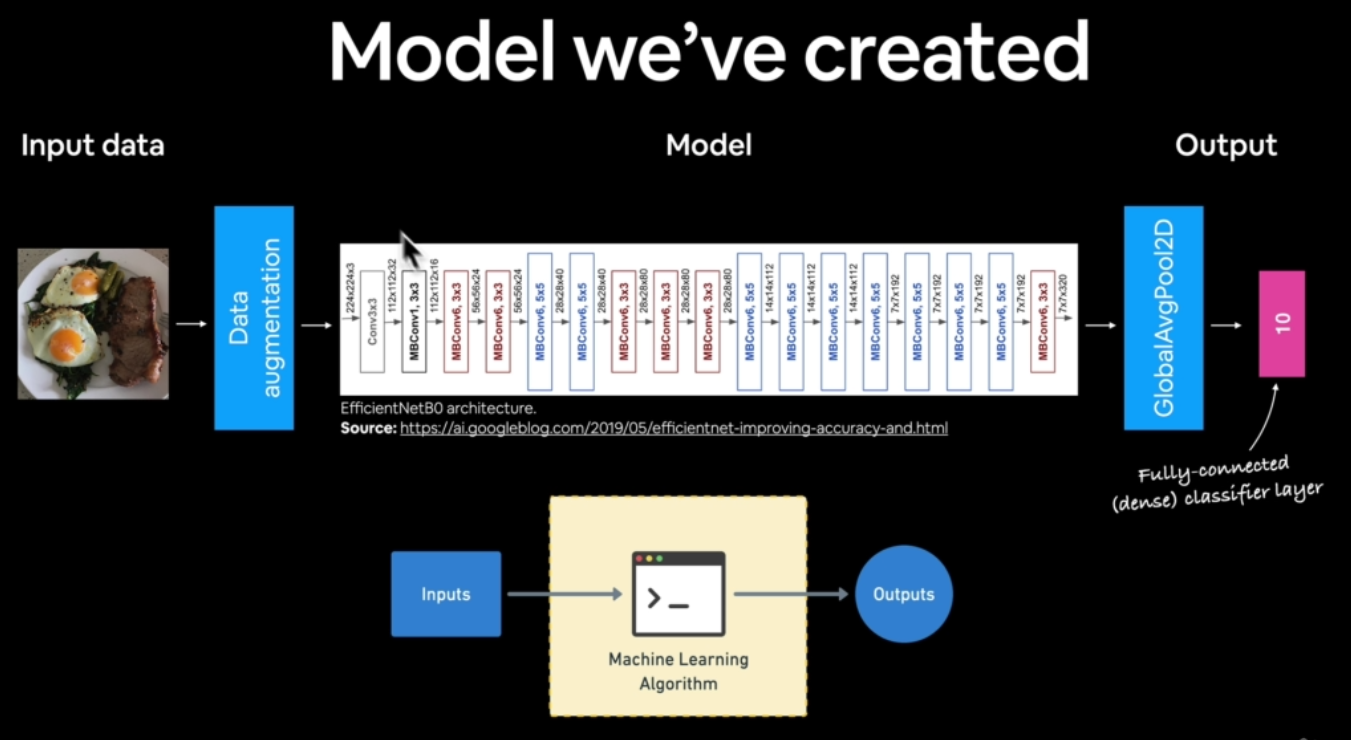

In [10]:
# Get a summmary of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 blobal_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [11]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs for quick exp
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # validate on 15% of test data during training
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 94s 325ms/step - loss: 3.4620 - accuracy: 0.2544 - val_loss: 2.5355 - val_accuracy: 0.4478
Epoch 2/5
237/237 [==============================] - 56s 234ms/step - loss: 2.3475 - accuracy: 0.4630 - val_loss: 2.1684 - val_accuracy: 0.4775
Epoch 3/5
237/237 [==============================] - 54s 227ms/step - loss: 1.9779 - accuracy: 0.5271 - val_loss: 1.9868 - val_accuracy: 0.5087
Epoch 4/5
237/237 [==============================] - 51s 213ms/step - loss: 1.7584 - accuracy: 0.5748 - val_loss: 1.8684 - val_accuracy: 0.5254
Epoch 5/5
237/237 [==============================] - 47s 195ms/step - loss: 1.6173 - accuracy: 0.6017 - val_loss: 1.8727 - val_accuracy: 0.5114


In [12]:
# Evaluate on the whole test dataset
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 58s 74ms/step - loss: 1.7128 - accuracy: 0.5531


[1.7127519845962524, 0.5530692934989929]

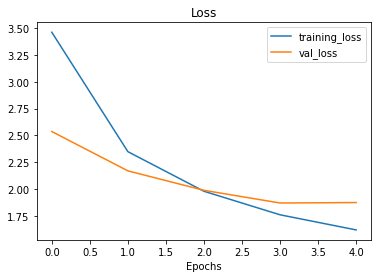

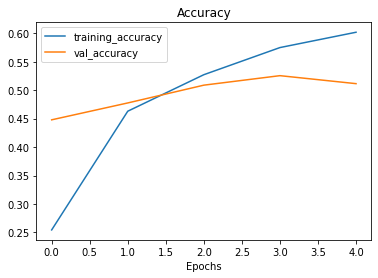

In [13]:
# Plot loss curves, overfitting :P
plot_loss_curves(history_all_classes_10_percent)

## Fine-tuning

In [14]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False


In [23]:
# Recompile model with lower learning rate (best practice to lower lr when unfreeze layers)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
blobal_avg_pool_layer True
output_layer True


In [17]:
# Check wich layres are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [24]:
# Fine tune for 5 more epochs were we left off last traning
initial_epochs = 5
fine_tune_epochs = initial_epochs + 5

# Refit the model
history_fine_tune_all_classes_ten_percent = model.fit(train_data_all_10_percent,
                                                           epochs=fine_tune_epochs,
                                                           validation_data=test_data,
                                                           validation_steps=int(0.15 * len(test_data)),
                                                           initial_epoch=history_all_classes_10_percent.epoch[-1],
                                                           callbacks=[create_tensorboard_callback(dir_name="transfer_lerning",
                                                                                                  experiment_name="10_percent_all_classes_last_five_layers_fine_tuned")])

Saving TensorBoard log files to: transfer_lerning/10_percent_all_classes_last_five_layers_fine_tuned/20220924-225651
Epoch 5/10
237/237 [==============================] - 52s 190ms/step - loss: 1.3502 - accuracy: 0.6516 - val_loss: 1.9073 - val_accuracy: 0.5050
Epoch 6/10
237/237 [==============================] - 41s 170ms/step - loss: 1.2437 - accuracy: 0.6679 - val_loss: 1.8285 - val_accuracy: 0.5215
Epoch 7/10
237/237 [==============================] - 42s 175ms/step - loss: 1.1569 - accuracy: 0.6923 - val_loss: 1.8680 - val_accuracy: 0.5180
Epoch 8/10
237/237 [==============================] - 40s 169ms/step - loss: 1.0791 - accuracy: 0.7083 - val_loss: 1.8320 - val_accuracy: 0.5262
Epoch 9/10
237/237 [==============================] - 38s 157ms/step - loss: 1.0321 - accuracy: 0.7246 - val_loss: 1.8014 - val_accuracy: 0.5278
Epoch 10/10
237/237 [==============================] - 38s 159ms/step - loss: 0.9726 - accuracy: 0.7407 - val_loss: 1.8364 - val_accuracy: 0.5275


In [26]:
# Evaluate the fine tuned model
results_fine_tune_10_percent_all_classes = model.evaluate(test_data)
results_fine_tune_10_percent_all_classes

790/790 [==============================] - 58s 73ms/step - loss: 1.6204 - accuracy: 0.5738


[1.6203621625900269, 0.573782205581665]

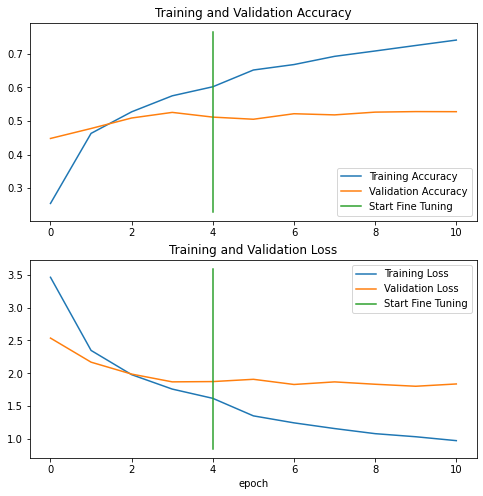

In [28]:
# Check the loss curves
compare_historys(history_all_classes_10_percent,
                 history_fine_tune_all_classes_ten_percent,
                 initial_epochs=5)